In [1]:
from astropy.samp import SAMPIntegratedClient
def samp_script_transmit(script):
    """ Sending an Aladin script over SAMP.

        Parameters
        ----------
        script : str
        Aladin script command
        
        Returns
        -------
        Transmit a Aladin command when SAMP Hub is running.
    """
    
    client = SAMPIntegratedClient()
    client.connect()
    params = {}

    message = {}
    message ["samp.mtype"] = "script.aladin.send"
    message ["samp.params"] = {'script': script}
    
    client.notify_all(message)
    client.disconnect()

In [2]:
url= 'file:///home/elisa/Scaricati/all_skymaps/Publication/GW190425_PublicationSamples.fits'
script = 'load ' + url
from tkinter import messagebox

try:
    samp_script_transmit(script)
except:
    messagebox.showwarning("Title", "Before running a function, you have to define it through the 'def' command.")
    messagebox.showerror("Title", "Please, go back and run the code which defines 'samp_script_transmit'.") 
    messagebox.showerror("Title", "Please, run Aladin.")

In [3]:
from astroquery.vizier import VizierClass
from astropy.coordinates import SkyCoord
from ligo.skymap.io import read_sky_map
from ligo.skymap.postprocess import crossmatch
import numpy as np
import matplotlib.pyplot as plt
vizier = VizierClass(row_limit=-1, columns=['GWGC', 'Bmag', 'e_Bmag', '_RAJ2000', '_DEJ2000', 'Dist', 'e_Dist'])
cat, = vizier.get_catalogs('VII/281/glade2')
coordinates = SkyCoord(cat['_RAJ2000'], cat['_DEJ2000'], cat['Dist'])
#prendo una delle skymap e applico crossmatch: ottengo lista delle galassie con probabilità 90%
skymap= read_sky_map(url, moc=True)
result = crossmatch(skymap, coordinates)
#aggiungo alla tabella la probabilità di ogni galassia
tabella=cat[result.searched_prob_vol < 0.9]
tabella['dP-dV']=result.probdensity_vol[result.searched_prob_vol < 0.9].round(10)
len(tabella)

70136

In [4]:
Bmag1=tabella['Bmag']
Dist1=tabella['Dist'] 
senzaBmag=0 
senzadist=0 
Bmag=[] 
indici=[] 
Dist=[]

for i in range(len(Bmag1)):
    if type(Bmag1[i])==np.ma.core.MaskedConstant:
        senzaBmag+=1 
    else: 
        if type(Dist1[i])==np.ma.core.MaskedConstant: 
            senzadist+=1 
        else: 
            Bmag.append(Bmag1[i]) 
            indici.append(i) 
            Dist.append(Dist1[i])

print(len(Bmag)) 
print(max(Dist))

67057
284.646114088


In [5]:
d=np.array(Dist)
m=np.array(Bmag)
M=m-5*np.log10(d*(10**5))
Lsole=3.83e33
Msole=4.72
L=Lsole*10**((Msole-M)/2.5)

h=0.7
Lb0=2.16e33
Lb=1.2e10*(h**(-2))*Lb0
xtot=L/Lb
#definizione funzione schechter
def Calculate_Shell_Size(r1,r2):
    volume = (4./3. * pow(r2,3) * np.pi - 4./3. * pow(r1,3) * np.pi) # using the provided lum dist
    return volume

def Schechter(lum, r1, r2): # calculates the value of the integral of the schecter function with the provided data 
    volume = Calculate_Shell_Size(r1,r2)
    sigma = phi * np.power(lum, alfa) * np.power(np.e,-lum) * volume * (0.7*0.7*0.7)##(0.7)^3 è il deltax?
    return sigma

h=0.7
phi=(1.6e-2)*(h**3)
a=-1.07
alfa=-0.07
skymap, header = read_sky_map(url)
distmean=header['distmean']
diststd=header['diststd']
R1=distmean-3*diststd
R2=distmean+3*diststd

67057
66946


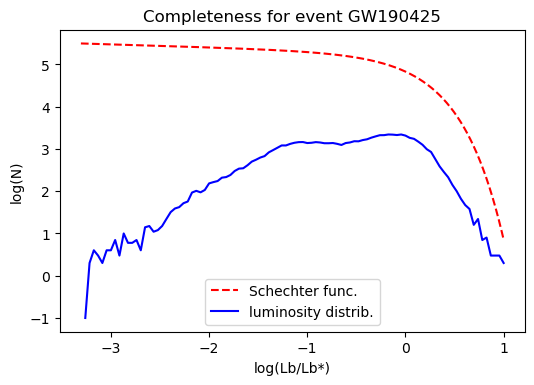

In [6]:
x=[]
for i in range(len(xtot)):
    if d[i]>=R1:
        if d[i]<=R2:
            x.append(xtot[i])
print(len(xtot))
print(len(x))
t=np.arange(0.0005, 10, 0.0001)
xarrk=np.logspace(-3.3,1,100)
Somme=[]
#calcolo il numero di galassie con x contenuta in un intervallo
for i in range(len(xarrk)-1):
    Min=xarrk[i]
    Max=xarrk[i+1]
    somma=0
    for j in range(len(x)):
        if x[j]>=Min:
            if x[j]<=Max:
                somma+=1
    if somma==0:
        if i==0:
            somma=0.1
            Somme.append(somma)
        else:
            Somme.append(Somme[i-1])
    else:
        Somme.append(somma)
xarrk_1=xarrk[1:]
fig= plt.figure(dpi=100)
plt.plot(np.log10(t), [np.log10(y) for y in Schechter(t, R1, R2)], 'r--', label='Schechter func.')
plt.plot(np.log10(xarrk_1), np.log10(Somme), 'b-', label='luminosity distrib.')
plt.title('Completeness for event GW190425')
plt.legend(loc='lower center')
plt.xlabel('log(Lb/Lb*)')
plt.ylabel('log(N)')
#plt.savefig('completezza evento.png', dpi=120)
plt.show()

In [7]:
dm=str(distmean)
dstd=str(diststd)

In [8]:
import numpy as np
import mocpy
import healpy as hp
from mocpy import MOC

# Read Galactic Dust Reddening frpm CADE data server
ext_map,h = hp.read_map('http://cade.irap.omp.eu/documents/Ancillary/EBV_SFD98/EBV_SFD98_1_512.fits', nest=True, h=True)

# Set pixel range from 0.5 up to the highest value.
index = np.nonzero((ext_map >= 0.5)& (ext_map <= 1000))

# set MOC order
depth=9

# Create and write a MOC from Galactic Dust Reddening
moc_low_ext = mocpy.MOC.from_healpix_cells(index[0],  np.ones_like(index[0])*depth)
moc_low_ext.write('ext_map.fits', overwrite=True)

# Download  sky map of GW190425 from GraceDB.
!curl -O https://gracedb.ligo.org/api/superevents/S190425z/files/bayestar.fits.gz

# Define the 90% credible region 
!ligo-skymap-contour-moc bayestar.fits.gz  -c 90  --output 'GW190425_90cr.fits'

# Load MOC files
GW190425_90cr = MOC.from_fits('GW190425_90cr.fits')
ext_map = MOC.from_fits('ext_map.fits')
# Measure intersection
intersection = GW190425_90cr.intersection(ext_map)

intersection_area = intersection.sky_fraction*41253
print('The intersection sky area is {:.2f} sq. deg.'.format(intersection_area))

/home/elisa/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(
/home/elisa/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 512
  warnings.warn("NSIDE = {0:d}".format(nside))
/home/elisa/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = NESTED in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/home/elisa/anaconda3/lib/python3.8/site-packages/healpy/fitsfunc.py:428: UserWarning: INDXSCHM = IMPLICIT
  warnings.warn("INDXSCHM = {0:s}".format(schm))


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:19 --:--:--     0curl: (6) Could not resolve host: gracedb.ligo.org
The intersection sky area is 1263.30 sq. deg.


In [9]:
import tkinter
from pandas import DataFrame
from matplotlib.backends.backend_tkagg import (
    FigureCanvasTkAgg, NavigationToolbar2Tk)
# Implement the default Matplotlib key bindings.
from matplotlib.backend_bases import key_press_handler
from matplotlib.figure import Figure

def embed_matlib(figure):
    root = tkinter.Tk()
    root.wm_title("Embedding in Tk")
    canvas = FigureCanvasTkAgg(figure, master=root)  # A tk.DrawingArea.
    canvas.draw()
    canvas.get_tk_widget().pack(side=tkinter.TOP, fill=tkinter.BOTH, expand=1)

    #toolbar = NavigationToolbar2Tk(canvas, root)
    #toolbar.update()
    #canvas.get_tk_widget().pack(side=tkinter.TOP, fill=tkinter.BOTH, expand=1)

    def _quit():
        root.quit()     # stops mainloop
        root.destroy()  # this is necessary on Windows to prevent
                    # Fatal Python Error: PyEval_RestoreThread: NULL tstate

    #label = tkinter.Label(text='Your current Sky Map is: ' + url, height=4)
    #label.pack(side=tkinter.TOP)
    
    labelText = tkinter.StringVar()
    labelText.set('Mean distance='+dm + '\n'
                  'Standard deviation of distance='+dstd + '\n'
                  'Intersection area= {:.2f} sq. deg.'.format(intersection_area) + '\n'
                  'Your current Sky Map is available here:\n' + url)
    labelDir = tkinter.Label(textvariable = labelText, height=5)
    labelDir.pack(side=tkinter.TOP)
    
    button = tkinter.Button(master=root, text="Quit", command=_quit)
    button.pack(side=tkinter.BOTTOM)

    tkinter.mainloop()

In [10]:
embed_matlib(fig)